In [1]:
import numpy as np
import pandas as pd

/home/surchs/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "/home/surchs/.config/matplotlib/matplotlibrc", line #405
  (fname, cnt))


In [2]:
# Paths
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

In [104]:
# Basic variables from the data
age_full = pheno['AGE_AT_SCAN'].values
age_min = np.min(age_full)
age_max = np.max(age_full)
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]
site_number = len(site_list)
age_range = age_max - age_min

In [4]:
def gen_window(win_range, box_number, start_age):
    """
    Generate a window for the uniform sampling
    """
    # And the divisions between the boxes
    window = np.zeros((2,box_number))
    # Generate the lower edges of the boxes
    window[0,:] = np.linspace(0, win_range, box_number, endpoint=False) + start_age
    window[1,:] = np.linspace(window[0,0], win_range, box_number) + start_age
    
    return window

In [5]:
def get_boxsubs(site, window):
    """
    Returns a vector of subject numbers
    corresponding to the boxes in window
    """
    # Get the number of boxes in the window
    box_number = window.shape[1]
    # Convert the site into an array
    site = np.array(site)
    # Compute the number of subjects in each box
    box_subs = [np.sum(np.logical_and(site>window[0,idx],site<=window[1,idx])) for idx in np.arange(box_number)]
    # Convert the number of box subs into an array
    box_subs = np.array(box_subs)
    
    return box_subs

In [6]:
def opt_sites(site_subs):
    """
    Find the optimal sites to maximize number 
    of subjects
    """
    # Get the number of sites
    site_number = site_subs.shape[0]
    box_number = site_subs.shape[1]
    # Get the smallest number per box
    min_subs = np.min(site_subs,1)
    # Sort the sites by subjects per box
    site_sort = np.argsort(min_subs)
    # Iteratively remove sites and see if 
    # the total number of subjects improves
    sub_vec = np.zeros((site_number,))
    for idx in np.arange(site_number):
        # Slice the sites
        tmp_site_idx = site_sort[idx:]
        # Get the number of remaining sites
        tmp_site_number = len(tmp_site_idx)
        # Get the minimal number of subjects
        tmp_min = np.min(site_subs[tmp_site_idx,:])
        # Get the total number of subjects
        tmp_total = tmp_min * tmp_site_number * box_number
        sub_vec[idx] = tmp_total
    # Find the set of sites with the largest number
    # of subjects
    max_idx = np.argmax(sub_vec)
    sites = site_sort[max_idx:]
            
    return sites

In [7]:
def opt_subjects(site_list, win_range, box_number, age_full, n_windows=40):
    """
    Optimizes the number of subjects across sites
    by generating and shifting a window of ages
    divided into boxes
    
    Returns:
        number of subjects
        optimal window
        list of sites
    """
    # Find the minimal and maximal age values
    age_min = np.min(age_full)
    age_max = np.max(age_full)
    age_range = age_max - age_min
    # Compute the window step
    win_shift = age_range - win_range
    win_step = win_shift / n_windows
    # Compute the starting ages for the windows
    start_ages = np.arange(0,win_shift+0.1, win_step) + age_min
    
    # Prepare a list for the results
    res_list = list()
    sub_vec = np.zeros((n_windows))
    # Iterate through the different windows and 
    # find the maximum number of subjects
    for win_id in np.arange(n_windows):
        start_age = start_ages[win_id]
        # Generate the window
        window = gen_window(win_range, box_number, start_age)
        # Iterate through sites and collect number 
        # of subjects per box for all of them
        site_subs = np.zeros((site_number, box_number))
        for s_id, site in enumerate(site_list):
            site_subs[s_id, :] = get_boxsubs(site, window)

        # Find the optimal sites for this window and box
        sites = opt_sites(site_subs)
        # Compute the total number of subjects
        total_subjects = np.min(site_subs[sites,:]) * len(sites) * box_number
        sub_vec[win_id] = total_subjects
        res_list.append((total_subjects, sites, window))
    return np.max(sub_vec)

## Let's iterate over a number of parameters and find the best subject sample for them
Now that we know the thing works

In [40]:
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

windows = np.arange(1,50,0.5)
boxes = np.arange(2,40)

results = np.zeros((100,40))
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        results[w_id, b_id] = opt_subjects(site_list, win_range, box_number, age_full)

In [8]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


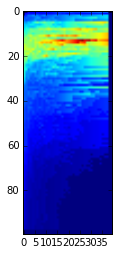

In [41]:
plt.imshow(results)

In [42]:
np.max(results)

672.0

In [43]:
np.argwhere(results==np.max(results))

array([[13, 26]])

In [19]:
windows[13]

7.5

In [37]:
boxes[17]

19

In [25]:
win_range = 7.5
box_number = 19
opt_subjects(site_list, win_range, box_number, age_full)

608.0

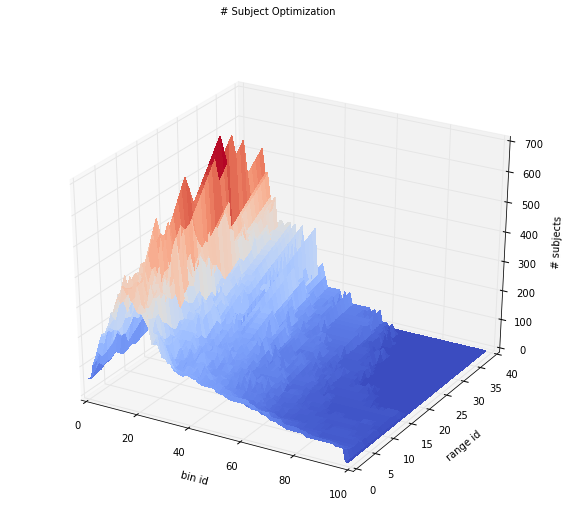

In [44]:
a, b = results.shape
X, Y = np.mgrid[:a, :b]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
surf = ax.plot_surface(X,Y,results,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_xlabel('bin id')
ax.set_ylabel('range id')
ax.set_zlabel('# subjects')
fig.suptitle('# Subject Optimization')

# Test Case to make sure things work
Have my own sample and make sure I get the correct number of subjects back. Only way to be sure the thing works correctly

In [9]:
n_sites = 10
full = np.random.random((80))*20 + 20
medium = np.random.random((20))*20 + 20
empty = np.random.random((10))*20 + 20

In [10]:
site_list = [list(full),
              list(full),
              list(full),
              list(full),
              list(full),
              list(medium),
              list(medium),
              list(medium),
              list(empty),
              list(empty)]
num_subjects = 5*100 + 3*70 + 2*10
opt_subjects = 8*70

In [11]:
# Define some parameters
win_range = 19.9
box_number = 2
n_windows = 10

In [12]:
# Find the minimal and maximal age values
age_min = 20
age_max = 40
age_range = age_max - age_min
# Compute the window step
win_shift = age_range - win_range
win_step = win_shift / n_windows
# Compute the starting ages for the windows
start_ages = np.arange(0,win_shift+0.1, win_step) + age_min

In [13]:
# Prepare a list for the results
res_list = list()
sub_vec = np.zeros((n_windows))
# Iterate through the different windows and 
# find the maximum number of subjects
for win_id in np.arange(n_windows):
    start_age = start_ages[win_id]
    # Generate the window
    window = gen_window(win_range, box_number, start_age)
    # Iterate through sites and collect number 
    # of subjects per box for all of them
    site_subs = np.zeros((site_number, box_number))
    for s_id, site in enumerate(site_list):
        site_subs[s_id, :] = get_boxsubs(site, window)
        
    # Find the optimal sites for this window and box
    sites = opt_sites(site_subs)
    # Compute the total number of subjects
    total_subjects = np.min(site_subs[sites,:]) * len(sites) * box_number
    sub_vec[win_id] = total_subjects
    res_list.append((total_subjects, sites, window))
print np.max(sub_vec)

360.0


## Draw an actual sample
So far, things have been quite theoretical. Let's get the details of the theoretical sample and make an actual list of subjects to be sure that we can really get a uniform sample of over 600 subjects.

First, I will change the function to return some information on the sample with the optimal number

In [37]:
def opt_subjects(site_list, win_range, box_number, age_full, n_windows=40):
    """
    Optimizes the number of subjects across sites
    by generating and shifting a window of ages
    divided into boxes
    
    Returns:
        number of subjects
        optimal window
        list of sites
    """
    # Find the minimal and maximal age values
    age_min = np.min(age_full)
    age_max = np.max(age_full)
    age_range = age_max - age_min
    # Compute the window step
    win_shift = age_range - win_range
    win_step = win_shift / n_windows
    # Compute the starting ages for the windows
    start_ages = np.arange(0,win_shift+0.1, win_step) + age_min
    
    # Prepare a list for the results
    res_list = list()
    sub_vec = np.zeros((n_windows))
    # Iterate through the different windows and 
    # find the maximum number of subjects
    for win_id in np.arange(n_windows):
        start_age = start_ages[win_id]
        # Generate the window
        window = gen_window(win_range, box_number, start_age)
        # Iterate through sites and collect number 
        # of subjects per box for all of them
        site_subs = np.zeros((site_number, box_number))
        for s_id, site in enumerate(site_list):
            site_subs[s_id, :] = get_boxsubs(site, window)

        # Find the optimal sites for this window and box
        sites = opt_sites(site_subs)
        # Compute the total number of subjects
        min_sub = np.min(site_subs[sites,:])
        total_subjects = min_sub * len(sites) * box_number
        sub_vec[win_id] = total_subjects
        res_list.append((total_subjects, sites, window, np.min(site_subs[sites,:])))
    
    # Get the optimal number of subjects
    max_sub_id = max_sub_id = np.argmax(sub_vec)
    best_result = res_list[max_sub_id]
    
    return best_result

In [38]:
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

windows = np.arange(7,10,0.5)
n_windows = len(windows)
boxes = np.arange(15,30)
n_boxes = len(boxes)

results = np.zeros((n_windows, n_boxes))
res_list = list()
iter_id = 0
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        res = opt_subjects(site_list, win_range, box_number, age_full)
        res_list.append(res)
        results[w_id, b_id] = res[0]

Get the optimal result from the results array. I'll get the 1D and the 2D index

In [52]:
ind2D = np.unravel_index(results.argmax(), results.shape)
ind1D = np.argmax(results)

Find the window length and the number of boxes

In [92]:
# Summary of optimal results
sub_num = results[ind2D]
window_length = windows[ind2D[0]]
box_number = boxes[ind2D[1]]
site_num = len(res_list[ind1D][1])
sites = list(pheno['SITE_ID'].unique()[res_list[ind1D][1]])
min_sub = res_list[ind1D][3]
print('Optimal Results:\n'
      '  number of subjects: {}\n'
      '  window length: {}\n'
      '  box number: {}\n'
      '  min sub: {}\n'
      '  site number: {}\n'
      '  sites: {}'.format(sub_num, window_length,
                           box_number, min_sub,
                           site_num,sites))

Optimal Results:
  number of subjects: 672.0
  window length: 7.5
  box number: 28
  min sub: 3.0
  site number: 8
  sites: ['UCLA_1', 'PITT', 'NYU', 'YALE', 'SDSU', 'UM_1', 'LEUVEN_2', 'TRINITY']


In [93]:
28*3

84

In [94]:
site = sites[1]

In [97]:
site

'PITT'

In [101]:
window = res_list[ind1D][2]

In [102]:
window

array([[  6.47      ,   6.73785714,   7.00571429,   7.27357143,
          7.54142857,   7.80928571,   8.07714286,   8.345     ,
          8.61285714,   8.88071429,   9.14857143,   9.41642857,
          9.68428571,   9.95214286,  10.22      ,  10.48785714,
         10.75571429,  11.02357143,  11.29142857,  11.55928571,
         11.82714286,  12.095     ,  12.36285714,  12.63071429,
         12.89857143,  13.16642857,  13.43428571,  13.70214286],
       [ 12.94      ,  12.97814815,  13.0162963 ,  13.05444444,
         13.09259259,  13.13074074,  13.16888889,  13.20703704,
         13.24518519,  13.28333333,  13.32148148,  13.35962963,
         13.39777778,  13.43592593,  13.47407407,  13.51222222,
         13.55037037,  13.58851852,  13.62666667,  13.66481481,
         13.70296296,  13.74111111,  13.77925926,  13.81740741,
         13.85555556,  13.8937037 ,  13.93185185,  13.97      ]])

In [106]:
np.sum(np.logical_and(age_full>6.4, age_full<14))

490

In [96]:
pheno.loc[pheno['SITE_ID']==site]

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
489,PITT,50002,1,1,16.77,1,Ambi,NaN,103,116,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
490,PITT,50003,1,1,24.45,1,R,NaN,124,128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
491,PITT,50004,1,1,19.09,1,R,NaN,113,108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
492,PITT,50005,1,1,13.73,2,R,NaN,119,117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
493,PITT,50006,1,1,13.37,1,L,NaN,109,99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
494,PITT,50007,1,1,17.78,1,R,NaN,110,106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
495,PITT,50008,1,1,32.45,1,R,NaN,123,123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
496,PITT,50009,1,1,33.86,1,R,NaN,126,118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
497,PITT,50010,1,1,35.20,1,L,NaN,81,81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
498,PITT,50011,1,1,16.93,1,L,NaN,111,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


In [89]:
pheno.head()

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.4,1,R,NaN,126,118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.9,1,Ambi,NaN,107,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.2,1,R,NaN,93,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.8,1,R,NaN,106,94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.6,2,Ambi,NaN,133,135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
